In [4]:
# # GPU configuration (if available)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
#v7
import os
import pickle
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm

dataset_dir = "dataset"
output_dir = "output_cropped"  # Directory to save cropped .p files
os.makedirs(output_dir, exist_ok=True)



# Classes list (make sure this matches your class mapping)
classes = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
           'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50',
           'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

# Desired size of cropped images
TARGET_SIZE = (32, 32)

def process_image_and_save_signs(images_path, labels_path):
    """
    For each image in images_path, read YOLO annotation from labels_path,
    crop out each detected object, resize, and return arrays of cropped images and their labels.
    """
    X = []
    y = []

    image_files = os.listdir(images_path)
    for image_name in tqdm(image_files, desc=f"Processing {images_path}"):
        if not image_name.lower().endswith(('.jpg', '.png')):
            continue

        image_path = os.path.join(images_path, image_name)
        label_path = os.path.join(labels_path, image_name.rsplit('.', 1)[0] + ".txt")

        # If label file doesn't exist or can't be read, skip
        if not os.path.exists(label_path):
            continue

        # Read the original image
        image = cv2.imread(image_path)
        if image is None:
            continue

        # Read annotations
        with open(label_path, 'r') as f:
            annotations = f.readlines()

        image_height, image_width, _ = image.shape

        # Process each bounding box in the YOLO format
        for annotation in annotations:
            parts = annotation.strip().split()
            if len(parts) < 5:
                continue
            class_id, x_center, y_center, width, height = parts
            class_id = int(class_id)
            x_center = float(x_center)
            y_center = float(y_center)
            width = float(width)
            height = float(height)

            # Convert normalized YOLO coords to pixel coords
            x_min = int((x_center - width / 2) * image_width)
            y_min = int((y_center - height / 2) * image_height)
            x_max = int((x_center + width / 2) * image_width)
            y_max = int((y_center + height / 2) * image_height)

            # Ensure coordinates are within image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image_width, x_max)
            y_max = min(image_height, y_max)

            # Crop the sign from the original image
            cropped_img = image[y_min:y_max, x_min:x_max]
            if cropped_img.size == 0:
                continue

            # Resize cropped image to target size
            cropped_img = cv2.resize(cropped_img, TARGET_SIZE)

            # Append to arrays
            X.append(cropped_img)
            y.append(class_id)

    X = np.array(X)
    y = np.array(y)
    return X, y

splits = ["train", "valid", "test"]

for split in splits:
    images_path = os.path.join(dataset_dir, split, "images")
    labels_path = os.path.join(dataset_dir, split, "labels")

    X_split, y_split = process_image_and_save_signs(images_path, labels_path)

    # Save to .p file
    output_file = os.path.join(output_dir, f"{split}.p")
    with open(output_file, "wb") as f:
        pickle.dump({"features": X_split, "labels": y_split}, f)
    print(f"Saved {split} data to {output_file}")

# Load and verify
with open(os.path.join(output_dir, "train.p"), "rb") as f:
    train_data = pickle.load(f)
print(train_data.keys())
print(train_data['features'].shape, train_data['labels'].shape)

# Optional Preprocessing: Convert to grayscale, equalize, normalize as before
def preprocessing(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_eq = cv2.equalizeHist(img_gray)
    img_normalized = img_eq / 255.0
    return img_normalized

# Load all splits
with open(os.path.join(output_dir, "train.p"), "rb") as f:
    train = pickle.load(f)
with open(os.path.join(output_dir, "valid.p"), "rb") as f:
    valid = pickle.load(f)
with open(os.path.join(output_dir, "test.p"), "rb") as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Apply preprocessing
X_train_processed = np.array([preprocessing(img) for img in X_train])
X_validation_processed = np.array([preprocessing(img) for img in X_validation])
X_test_processed = np.array([preprocessing(img) for img in X_test])

# Add channel dimension for grayscale
X_train_processed = np.expand_dims(X_train_processed, axis=-1)
X_validation_processed = np.expand_dims(X_validation_processed, axis=-1)
X_test_processed = np.expand_dims(X_test_processed, axis=-1)




Processing dataset\train\images: 100%|██████████| 3527/3527 [00:12<00:00, 289.40it/s]


Saved train data to output_cropped\train.p


Processing dataset\valid\images: 100%|██████████| 801/801 [00:01<00:00, 493.43it/s]


Saved valid data to output_cropped\valid.p


Processing dataset\test\images: 100%|██████████| 637/637 [00:01<00:00, 441.01it/s]


Saved test data to output_cropped\test.p
dict_keys(['features', 'labels'])
(4298, 32, 32, 3) (4298,)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(32,(5,5),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes),activation='softmax'))
model.summary()

with tf.device('/GPU:0'):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_validation_processed, y_validation),
        epochs=50, batch_size=32,
        callbacks=[early_stopping]
    )

loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

Text(0.5, 0, 'epochs')

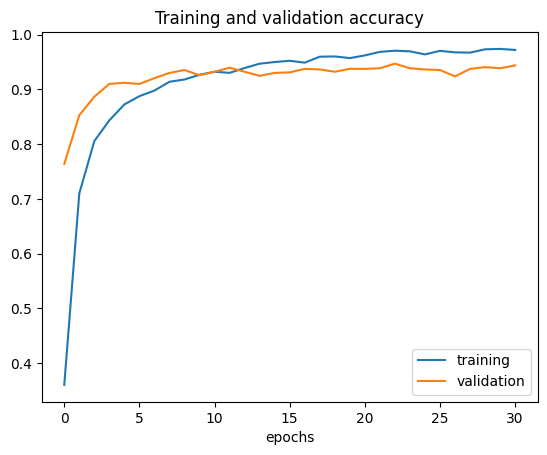

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epochs')


Text(0.5, 0, 'epochs')

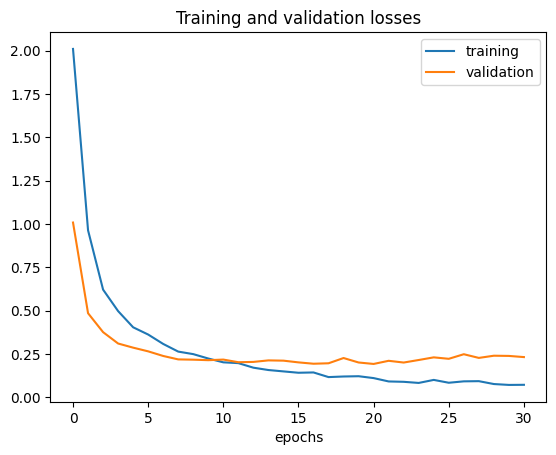

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and validation losses')
plt.xlabel('epochs')


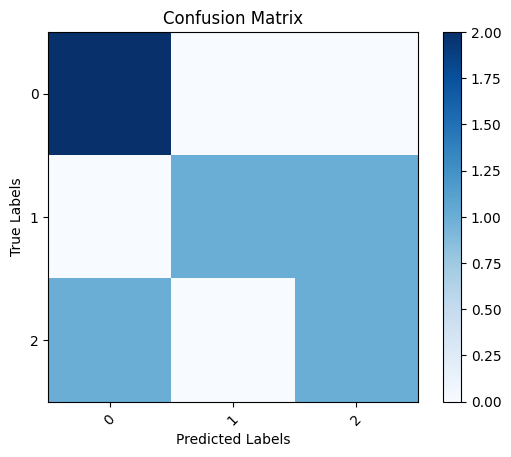

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# True and predicted labels
y_true = [0, 1, 2, 1, 0, 2]
y_pred = [0, 2, 2, 1, 0, 0]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true)))
plt.xticks(tick_marks, np.unique(y_true), rotation=45)
plt.yticks(tick_marks, np.unique(y_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [10]:
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"traffic_sign_model_{current_datetime}.h5"
model.save(filename)

25/25 [==============================] - 1s 6ms/step


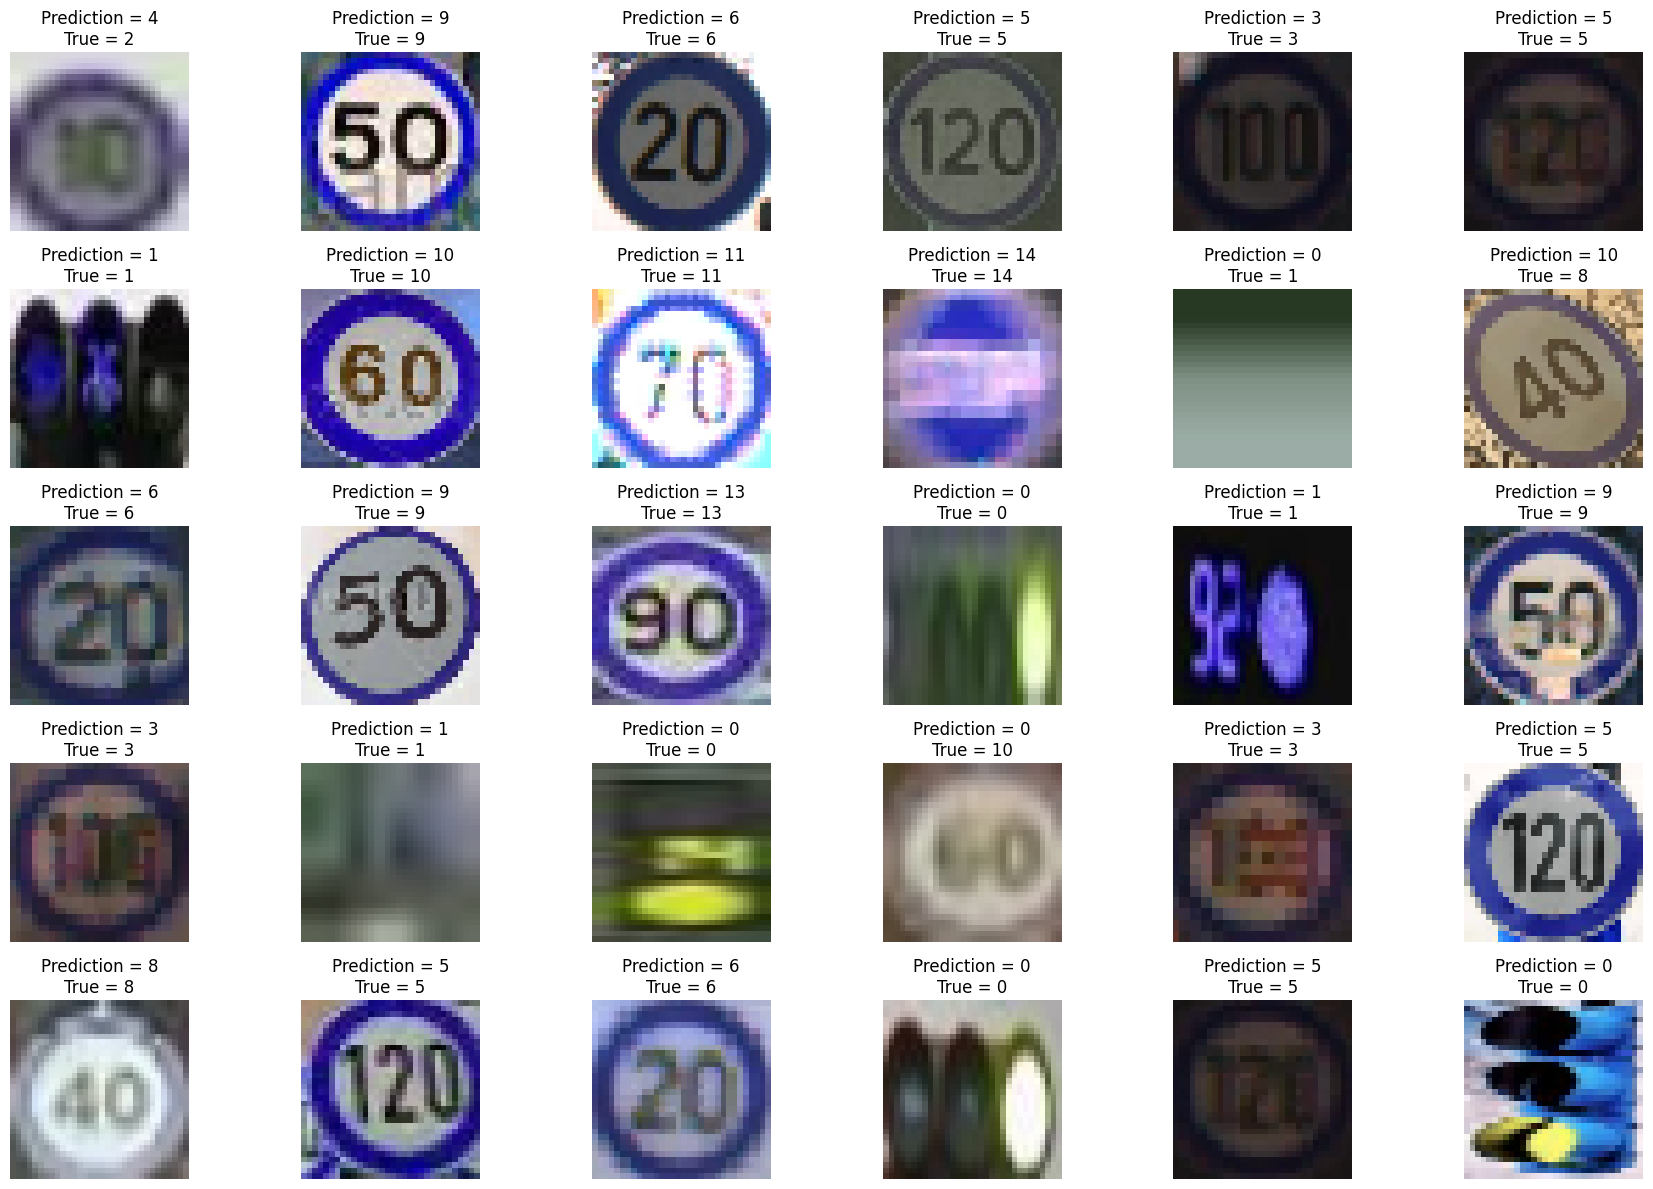

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
predictions = model.predict(X_test_processed)

# Convert probabilities to class indices
prediction = np.argmax(predictions, axis=1)

# True labels
y_true_label = y_test

# Randomly select 30 indices from the test dataset
random_indices = np.random.choice(len(X_test), 30, replace=False)

# Visualization of randomly selected predictions and true labels
fig, axes = plt.subplots(5, 6, figsize=(18, 12))  # 5 rows and 6 columns for 30 images
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(X_test[idx].squeeze(), cmap='gray')  # Use .squeeze() if images have shape (28, 28, 1)
    axes[i].set_title(f'Prediction = {prediction[idx]}\nTrue = {y_true_label[idx]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import gradio as gr
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the trained model (replace 'your_model.h5' with your actual model file path)
model = load_model(filename)

def predict_image(img):
    """
    Preprocess the image, make a prediction using the model, and return the result.
    """
    # Convert the image to grayscale
    img = img.convert("L")
    
    # Resize the image to the input size expected by the model
    img = img.resize((32, 32))  # Ensure this matches your model's input shape
    img_array = np.array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Process predictions as needed (example: return class with highest probability)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return f"Predicted Class: {predicted_class}"

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="Image Classification",
    description="Upload an image to get the model's prediction."
)

# Launch the Gradio app
interface.launch()


Running on local URL:  http://127.0.0.1:7860


c:\Users\Baby\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.40.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(



To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 1s 711ms/step
